<a href="https://colab.research.google.com/github/aluizakarl/dataAnalysisSEA/blob/master/hGlycinesAnalysis/differentialExpression_SEAchapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Glycine max* in response to the infection by the cyst nematode (*Heterodera glycines*)**


The soybean cyst nematode (SCN) is a significant pathogen impacting soybean crops worldwide, leading to major yield losses in the U.S., Brazil, and China. By infesting root systems and forming cysts, SCN causes stunted growth, chlorosis, and reduced yields, making it one of the most economically damaging plant diseases. Effective management of SCN is essential for maintaining soybean productivity and food security.

Genome-wide association studies (GWAS) are valuable for identifying genetic variants linked to complex traits, such as single nucleotide polymorphisms (SNPs). Integrating GWAS data with RNA-Seq gene expression analysis enhances the identification of functional candidate genes and provides insights into the mechanisms of SCN resistance.

This notebook analyzes gene expression data for 243 soybean [*Glycine max*] genes derived from published GWAS, employing statistical analyses and differential expression analysis with DESeq2. It exemplifies the integration of GWAS and gene expression data to identify candidate genes associated with cyst nematode resistance.

All analyses were performed by Ana Luiza M. Karl (github.com/aluizakarl). For any questions, please contact almkarl@lncc.br or open an issue in the GitHub repository.

## 1. Importing libraries and data

Installing and importing the necessary libraries

In [ ]:
%pip install pydeseq2
%pip install sanbomics
%pip install gseapy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import gseapy as gp
import seaborn as sns
from sanbomics.plots import volcano
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from google.colab import drive
from gseapy.plot import gseaplot

Loading the root expression data

In [ ]:
root = pd.read_csv('/content/geneList_root-bcc.tsv', sep='\t')
root_aux = root
root_aux

,Gene,SAMEA4395172,SAMD00133787,SAMD00025074,SAMEA4395174,SAMEA4395175,SAMEA4395176,SAMEA4395177,SAMEA4395173,SAMEA4395178,...,SAMN28000075,SAMN28000076,SAMN28000077,SAMN28000084,SAMN28000079,SAMN28000078,SAMN28000080,SAMN28000081,SAMN28000082,SAMN28000083
0,Glyma.02G001700,1057,1431,236,1140,688,980,1324,561,926,...,576,691,890,496,710,665,662,528,542,573
1,Glyma.02G025200,436,47,58,408,250,410,672,296,394,...,348,1373,1184,718,427,1093,407,356,1207,768
2,Glyma.02G072300,262,91,28,168,187,270,467,194,273,...,91,174,171,64,159,120,122,109,147,81
3,Glyma.02G145200,1247,923,162,1126,893,1247,1719,1017,924,...,1698,1962,2144,1618,1635,1486,1634,1468,1417,1629
4,Glyma.02G161600,264,23,53,215,119,156,248,162,150,...,141,183,171,133,141,106,139,161,102,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Glyma.19G120200,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
239,Glyma.19G137300,24,0,23,13,6,10,14,12,16,...,13,19,38,33,43,34,16,16,25,20
240,Glyma.19G161200,339,66,31,256,143,245,339,178,202,...,155,271,263,187,238,176,237,194,172,218
241,Glyma.19G229800,1724,83,150,1186,810,1052,1532,1000,884,...,1091,1522,1435,1180,1050,1053,1239,1235,923,928


##2. Cleaning and filtering data

Loading the sample informations

In [ ]:
infectedSamples = pd.read_csv('/content/infectedSamples.csv', sep='\t')
controlSamples = pd.read_csv('/content/controlSamples.csv', sep='\t')
infectedList = infectedSamples.iloc[:, 1]
controlList = controlSamples.iloc[:, 1]

samples = [*controlList, *infectedList]

Filtering by the samples IDs

In [ ]:
df = root[samples]
df = df.T
df.columns = root['Gene']
root=df

infectedSamples_df = root_aux[infectedList]
infectedSamples_df.index = root_aux['Gene']
controlSamples_df = root_aux[controlList]
controlSamples_df.index = root_aux['Gene']

Visualizing the data distribution

In [ ]:
infectedSamplesSum = infectedSamples_df.sum(axis=1)
infectedSamplesSum_s = infectedSamplesSum.sort_values(ascending=False)
infectedSamplesSum_s.describe()

,0
count,243.000000
mean,34177.506173
std,79337.884193
min,0.000000
25%,1739.000000
50%,10957.000000
75%,33410.000000
max,748252.000000


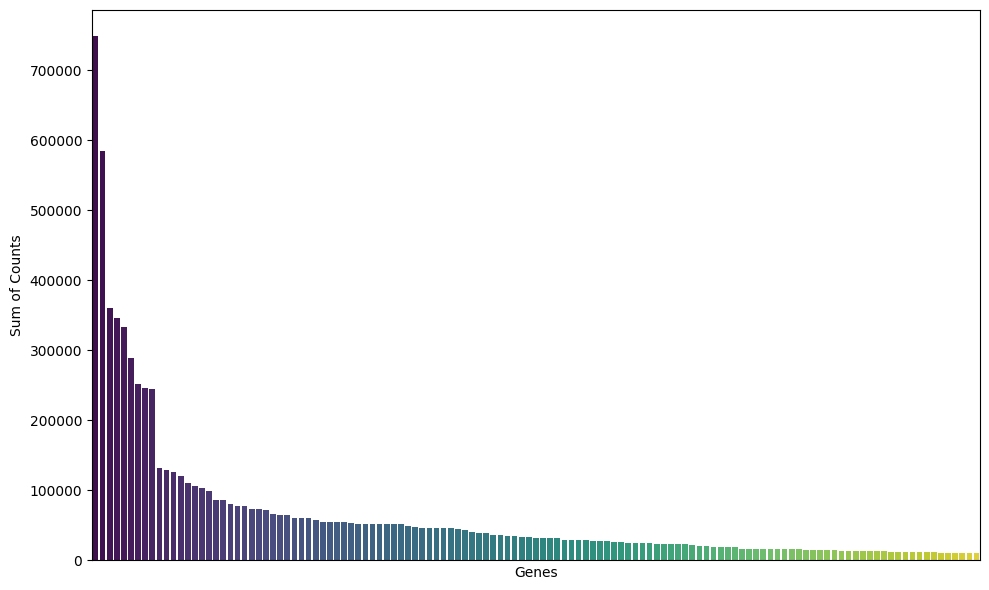

In [ ]:
#Filtering to improve the visualization
infectedSamplesSum = infectedSamplesSum_s[infectedSamplesSum_s > 10000]

plt.figure(figsize=(10, 6))
sns.barplot(x=infectedSamplesSum.index, y=infectedSamplesSum.values, palette="viridis")

plt.xlabel("Genes")
plt.ylabel("Sum of Counts")
plt.xticks([])

plt.tight_layout()
plt.show()

In [ ]:
controlSamplesSum = controlSamples_df.sum(axis=1)
controlSamplesSum_s = controlSamplesSum.sort_values(ascending=False)
controlSamplesSum_s.describe()

,0
count,243.000000
mean,19572.777778
std,46891.315938
min,0.000000
25%,1004.500000
50%,6143.000000
75%,18292.000000
max,434667.000000


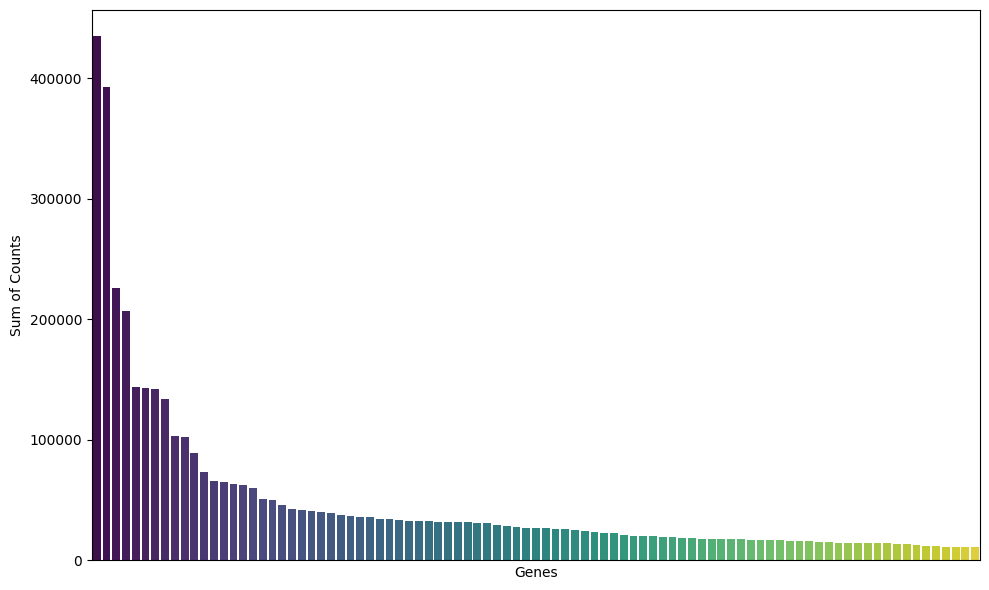

In [ ]:
#Filtering to improve the visualization

controlSamplesSum = controlSamplesSum_s[controlSamplesSum_s > 10000]

plt.figure(figsize=(10, 6))
sns.barplot(x=controlSamplesSum.index, y=controlSamplesSum.values, palette="viridis")

plt.xlabel("Genes")
plt.ylabel("Sum of Counts")
plt.xticks([])

plt.tight_layout()
plt.show()


In [ ]:
print(infectedSamplesSum_s['Glyma.09G278900'])
print(controlSamplesSum_s['Glyma.09G278900'])

590
460


Creating a pandas Dataframe with metadata information


In [ ]:
treatments = ['Infected'] * len(infectedList) + ['Control'] * len(controlList)

metadata = pd.DataFrame({
    'Sample': samples,
    'Treatment': treatments
})
metadata = metadata.set_index('Sample')

In [ ]:
# Verifying the NULL values
if not np.isfinite(root.values).all():
    print("Missing values detected:")
else:
    print("No missing values detected in the dataset.")

No missing values detected in the dataset.


## 3. DESeq2 analysis

In [ ]:
# Create a DeseqDataSet object for differential expression analysis
dds = DeseqDataSet(
    counts=root,            # A DataFrame containing raw count data for each gene/sample. Rows represent genes, and columns represent samples.
    metadata=metadata,      # A DataFrame containing sample annotations, such as treatment groups or experimental conditions.
    design_factors="Treatment"  # The column in the metadata DataFrame that specifies the experimental design or grouping factor.
)

In [ ]:
#Running Deseq2
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.95 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 2.60 seconds.

Fitting LFCs...
... done in 0.62 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 7 outlier genes.

Fitting dispersions...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.05 seconds.



### Running the statistical tests:

In [ ]:
stat_res = DeseqStats(dds, contrast= ('Treatment', 'Infected', 'Control'))
stat_res.summary()

Running Wald tests...
... done in 0.25 seconds.



Log2 fold change & Wald test p-value: Treatment Infected vs Control
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Gene                                                                         
Glyma.02G001700  1395.694566       -0.337616  0.288299 -1.171060  0.241575   
Glyma.02G025200   364.916963        0.279599  0.103883  2.691466  0.007114   
Glyma.02G072300   497.684252        0.354701  0.292653  1.212019  0.225505   
Glyma.02G145200  1071.140995       -0.293452  0.202807 -1.446955  0.147910   
Glyma.02G161600   178.949531       -0.299879  0.109110 -2.748421  0.005988   
...                      ...             ...       ...       ...       ...   
Glyma.19G120200     8.373850       -2.290239  0.857128 -2.671991  0.007540   
Glyma.19G137300    22.213872       -0.923754  0.250185 -3.692287  0.000222   
Glyma.19G161200   176.387902        0.108896  0.094736  1.149462  0.250366   
Glyma.19G229800   924.280948        0.087743  0.090023  0.974674  0.329722

In [ ]:
results = stat_res.results_df
results['Symbol'] = root_aux['Gene'].tolist()

### Visualizing results with Volcano plot

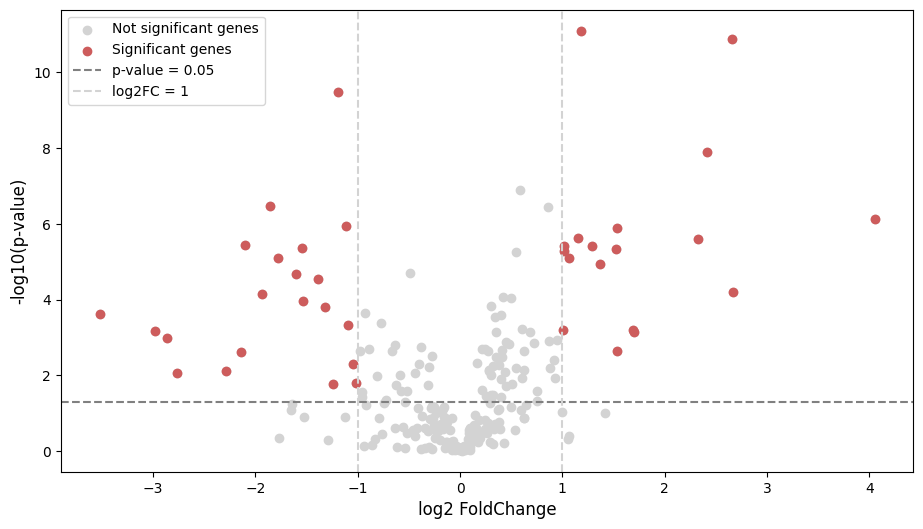

<Figure size 640x480 with 0 Axes>

In [ ]:
# Creating a new colunm -log10(pvalue)
results['-log10(pvalue)'] = -np.log10(results['pvalue'])

padj_threshold = 0.05
log2fc_threshold = 1

plt.figure(figsize=(11, 6))

plt.scatter(results['log2FoldChange'], results['-log10(pvalue)'], color='lightgray', label='Not significant genes')

significant = (results['padj'] < padj_threshold) & (abs(results['log2FoldChange']) > log2fc_threshold)
plt.scatter(results.loc[significant, 'log2FoldChange'], results.loc[significant, '-log10(pvalue)'],
            color='indianred', label='Significant genes')

plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--', label='p-value = 0.05')
plt.axvline(x=log2fc_threshold, color='lightgray', linestyle='--', label=f'log2FC = {log2fc_threshold}')
plt.axvline(x=-log2fc_threshold, color='lightgray', linestyle='--')

plt.xlabel('log2 FoldChange', fontsize=12)
plt.ylabel('-log10(p-value)', fontsize=12)

plt.legend(loc='upper left')

plt.show()
plt.savefig('volcano_plot.pdf', format='pdf')

### Selecting the significant genes

In [ ]:
sigs = results[(results.padj < 0.05)]
sigs = sigs[(abs(sigs.log2FoldChange) > 1)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,-log10(pvalue)
Gene,,,,,,,,
Glyma.04G062600,143.127025,-1.045510,0.371966,-2.810769,4.942324e-03,1.719069e-02,Glyma.04G062600,2.306069
Glyma.05G121700,289.616686,-3.520149,0.959699,-3.667971,2.444827e-04,1.724681e-03,Glyma.05G121700,3.611752
Glyma.05G204500,39.186290,-1.095629,0.312683,-3.503964,4.583877e-04,2.895080e-03,Glyma.05G204500,3.338767
Glyma.05G204600,293.453818,-1.774992,0.397693,-4.463225,8.073523e-06,9.226883e-05,Glyma.05G204600,5.092937
Glyma.05G204800,995.424220,-1.535194,0.397419,-3.862908,1.120452e-04,8.963616e-04,Glyma.05G204800,3.950607
Glyma.05G205900,103.105670,-2.765782,1.054759,-2.622193,8.736605e-03,2.557055e-02,Glyma.05G205900,2.058657
Glyma.06G134900,55.909220,1.532349,0.316136,4.847124,1.252640e-06,3.006335e-05,Glyma.06G134900,5.902174
Glyma.06G187300,318.033961,-1.540596,0.335720,-4.588927,4.455299e-06,6.506359e-05,Glyma.06G187300,5.351123
Glyma.07G191500,367.296330,-1.387772,0.332071,-4.179145,2.926071e-05,2.809028e-04,Glyma.07G191500,4.533715


In [ ]:
ranking =  sigs[['Symbol', 'log2FoldChange']].dropna().sort_values('log2FoldChange', ascending = False)
ranking.head(40)

,Symbol,log2FoldChange
Gene,,
Glyma.18G203500,Glyma.18G203500,4.050547
Glyma.07G195300,Glyma.07G195300,2.669280
Glyma.18G034600,Glyma.18G034600,2.660167
Glyma.10G173400,Glyma.10G173400,2.408299
Glyma.09G278900,Glyma.09G278900,2.323692
Glyma.18G193200,Glyma.18G193200,1.701241
Glyma.12G013500,Glyma.12G013500,1.688214
Glyma.06G134900,Glyma.06G134900,1.532349
Glyma.18G035200,Glyma.18G035200,1.530701


### Visualizing results with heatmap of the significant genes:

In [ ]:
dds.layers['log2'] =  np.log2(dds.layers['normed_counts'], where=dds.layers['normed_counts'] > 0)
dds.layers['log2']

array([[ 7.06945614,  9.12205109, 11.37702894, ...,  7.76879666,
         9.58116966,  5.69664688],
       [ 8.09902696,  8.33160315,  9.07599142, ...,  7.50809056,
         9.54356845,  4.93505122],
       [ 6.78086651,  8.72539621,  9.93722906, ...,  7.47467134,
         9.73457286,  5.2110109 ],
       ...,
       [10.53710493,  8.50853578,  7.18660769, ...,  7.45962618,
         9.62623082,  8.03460459],
       [11.39631913,  8.27409087,  7.44010083, ...,  6.16446638,
         9.84135137,  8.06628599],
       [10.75710948,  8.31488716,  6.89984966, ...,  7.26705863,
         9.86278756,  7.62421521]])

In [ ]:
dds_sigs = dds[:, sigs.index]

In [ ]:
grapher = pd.DataFrame(dds_sigs.layers['log2'].T, index=dds_sigs.var_names, columns=dds_sigs.obs_names)
with pd.option_context('mode.use_inf_as_na', True):
  grapher.dropna(inplace=True)
grapher

Sample,SAMN07599985,SAMN08633985,SAMN08634679,SAMN07430297,SAMN07430299,SAMN07430305,SAMN10169601,SAMN10721154,SAMN10721155,SAMN10721156,...,SAMN10721170,SAMN10721174,SAMN10721175,SAMN10721176,SAMN11476342,SAMN11476343,SAMN11476344,SAMN11476392,SAMN11476393,SAMN11476394
Gene,,,,,,,,,,,,,,,,,,,,,
Glyma.04G062600,3.411245,6.514064,4.240758,5.993553,5.269558,5.642241,5.999224,3.103686,4.835336,3.058667,...,9.164993,9.523820,7.155212,6.816566,7.374737,7.215651,7.191184,8.087072,7.870735,6.941072
Glyma.05G121700,2.733173,0.000000,0.000000,-1.140873,7.262422,6.424650,0.000000,8.673542,8.869606,6.028293,...,1.506781,9.581343,6.647065,10.672975,0.000000,0.000000,0.000000,0.279717,0.000000,0.000000
Glyma.05G204500,4.218600,3.952753,4.353969,5.783939,6.186537,4.726306,5.347148,6.376705,6.527214,4.058667,...,3.091744,6.341616,4.242674,6.947150,4.280761,2.893723,4.901678,4.367180,3.916539,5.183643
Glyma.05G204600,5.455639,6.785026,6.298474,5.580226,6.835411,5.106910,5.918304,6.688649,7.474746,6.916648,...,10.006627,9.327677,9.019398,8.835425,6.438302,6.009200,5.432192,6.980157,4.501501,7.020144
Glyma.05G204800,2.996207,9.739859,8.497954,9.273812,8.465610,6.283787,6.649710,7.574006,8.602502,9.198218,...,10.824194,10.360908,10.330137,9.370831,8.245657,8.319988,6.776147,9.496463,9.135707,9.183643
Glyma.05G205900,0.000000,0.000000,0.000000,0.000000,5.553012,5.338235,0.000000,8.042286,8.654532,5.602987,...,0.000000,7.778680,5.242674,8.647589,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Glyma.06G134900,7.466527,6.672017,7.001088,5.029052,4.802990,4.726306,7.715051,6.627248,6.304821,4.997266,...,5.207221,4.019688,4.062102,3.947150,4.165284,3.308761,4.979680,4.449642,1.916539,5.314887
Glyma.06G187300,6.886978,8.267627,7.768155,4.614014,7.837013,7.190678,7.384446,9.446502,9.509936,9.181063,...,9.339672,7.479120,8.183118,8.868762,6.280761,5.478686,5.539108,6.705982,5.238467,5.546213
Glyma.07G191500,6.870676,4.087054,4.556786,7.573372,7.181502,7.985649,5.644129,9.065618,9.992877,8.795632,...,9.288141,9.414645,10.341326,9.996579,7.624715,7.308761,7.316715,7.345806,7.408392,7.148877


In [ ]:
ordered_columns = metadata.sort_values(by='Treatment').index
grapher_ordered = grapher[ordered_columns].round(8)

sample_groups = metadata.loc[grapher_ordered.columns, 'Treatment']
group_colors = sample_groups.replace({'Infected': 'midnightblue', 'Control': 'darkgray'})

heatmap = sns.clustermap(grapher_ordered.round(4),
    z_score=0,
    metric='euclidean',
    method='ward',
    cmap='coolwarm',
    cbar_pos=(1.0, 0.71, 0.01, 0.1),
    row_cluster=True,
    col_cluster=False,
    col_colors=group_colors,
    vmin=-3
    )
heatmap.ax_heatmap.set_xticks([])
if heatmap.dendrogram_row is not None:
    row_order = heatmap.dendrogram_row.reordered_ind
    ordered_rows = grapher_ordered.index[row_order]

    heatmap.ax_heatmap.set_yticks(np.arange(len(ordered_rows)) + 0.5)
    heatmap.ax_heatmap.set_yticklabels(ordered_rows, rotation=0, va='center', fontsize=8)
plt.savefig('heatmap.pdf', format='pdf', bbox_inches='tight')
plt.show()


### Selecting the significant and up-regulated genes

In [ ]:
sigs_up = results[(results.padj < 0.05) & (results.log2FoldChange > 1)].sort_values('log2FoldChange', ascending = False)
sigs_up.shape

(18, 8)

### Visualizing results with heatmap of the significant and up-regulated genes:

In [ ]:
dds_sigs2 = dds[:, sigs_up.index]
grapher = pd.DataFrame(dds_sigs2.layers['log2'].T, index=dds_sigs2.var_names, columns=dds_sigs2.obs_names)
with pd.option_context('mode.use_inf_as_na', True):
  grapher.dropna(inplace=True)
grapher

Sample,SAMN07599985,SAMN08633985,SAMN08634679,SAMN07430297,SAMN07430299,SAMN07430305,SAMN10169601,SAMN10721154,SAMN10721155,SAMN10721156,...,SAMN10721170,SAMN10721174,SAMN10721175,SAMN10721176,SAMN11476342,SAMN11476343,SAMN11476344,SAMN11476392,SAMN11476393,SAMN11476394
Gene,,,,,,,,,,,,,,,,,,,,,
Glyma.18G203500,0.411245,0.595201,1.947976,2.766018,4.043998,5.424650,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.580321,0.000000,0.000000,0.279717,0.000000,0.791325
Glyma.07G195300,6.678031,8.290430,7.943461,4.600594,3.952368,3.320313,13.480596,3.326079,0.000000,3.058667,...,9.038163,9.780728,2.962567,2.246710,7.180234,7.331129,6.539108,7.537105,7.960933,5.598680
Glyma.18G034600,8.799262,6.655897,6.815873,6.238505,7.189048,4.642241,8.591455,6.103686,5.942251,6.404442,...,5.966213,5.711566,3.740174,4.334173,4.667784,4.893723,5.731753,4.923573,5.086464,4.113253
Glyma.10G173400,4.803562,8.387992,8.409047,8.026545,5.221303,5.805740,9.495539,3.840652,4.658458,4.281059,...,5.506781,6.126603,5.325137,5.456163,7.266822,8.128940,6.638643,6.409000,5.723894,4.598680
Glyma.09G278900,3.218600,2.402556,3.755331,5.087946,5.396670,3.552974,-1.367098,0.000000,0.134896,0.473704,...,0.000000,1.904211,1.740174,0.000000,3.387676,1.308761,1.731753,2.601645,4.238467,3.113253
Glyma.18G193200,3.870676,1.765126,0.947976,-1.140873,-0.393407,-1.001615,0.217865,3.518724,2.719859,3.058667,...,0.000000,0.319248,1.155212,0.000000,0.000000,1.308761,0.731753,0.000000,0.000000,0.791325
Glyma.12G013500,0.000000,1.917129,2.626048,2.946590,4.325411,3.642241,1.632902,1.518724,3.134896,4.174144,...,4.091744,0.319248,1.155212,3.054065,0.580321,0.000000,0.000000,2.601645,1.916539,0.791325
Glyma.06G134900,7.466527,6.672017,7.001088,5.029052,4.802990,4.726306,7.715051,6.627248,6.304821,4.997266,...,5.207221,4.019688,4.062102,3.947150,4.165284,3.308761,4.979680,4.449642,1.916539,5.314887
Glyma.18G035200,1.996207,0.595201,1.433403,1.318559,1.722070,-1.001615,1.217865,0.000000,1.719859,0.000000,...,1.506781,0.000000,0.000000,0.000000,1.580321,1.308761,0.731753,1.864680,1.916539,0.000000


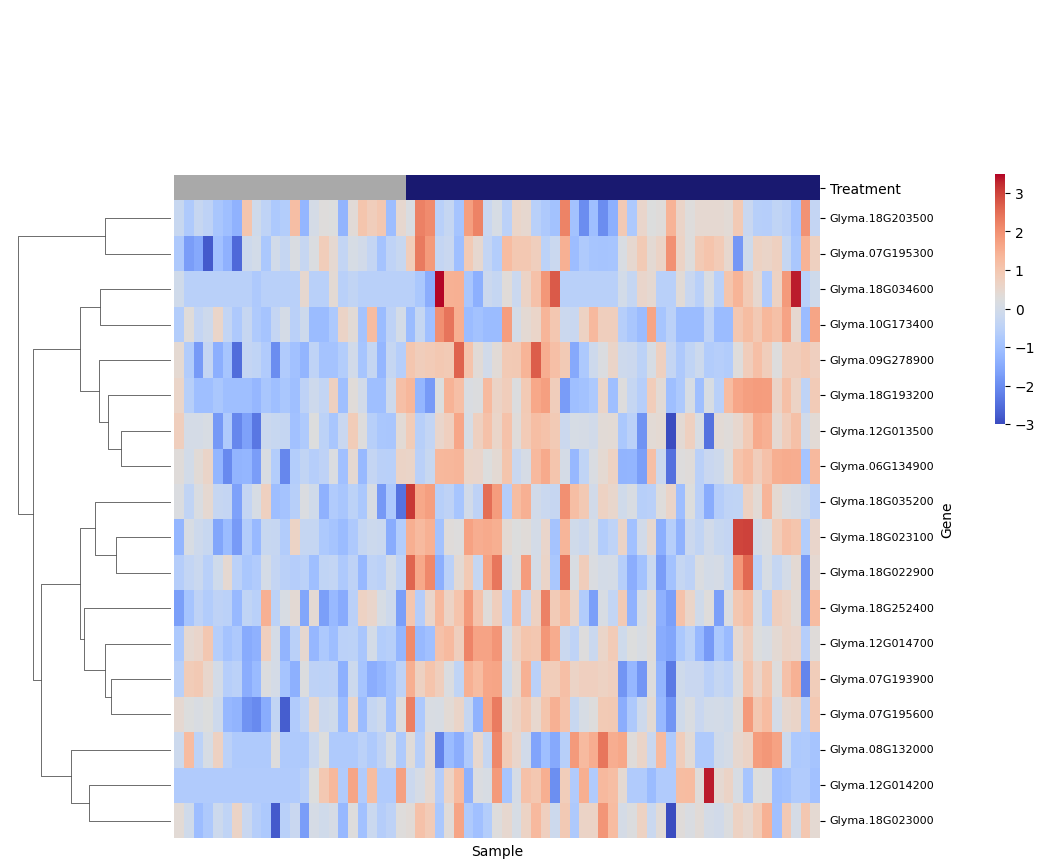

In [ ]:
ordered_columns = metadata.sort_values(by='Treatment').index
grapher_ordered = grapher[ordered_columns].round(8)

sample_groups = metadata.loc[grapher_ordered.columns, 'Treatment']
group_colors = sample_groups.replace({'Infected': 'midnightblue', 'Control': 'darkgray'})

heatmap = sns.clustermap(grapher_ordered.round(4),
    z_score=0,
    metric='euclidean',
    method='ward',
    cmap='coolwarm',
    cbar_pos=(1.0, 0.57, 0.01, 0.25),
    row_cluster=True,
    col_cluster=False,
    col_colors=group_colors,
    vmin=-3
    #
)
heatmap.ax_heatmap.set_xticks([])
heatmap.ax_heatmap.set_yticks(np.arange(grapher_ordered.shape[0]) + 0.5)
heatmap.ax_heatmap.set_yticklabels(grapher_ordered.index, fontsize=8, rotation=0, va='center')

plt.show()